# **Implementing sequence-to-sequence model with attention**
- Please make sure you use GPU by setting the menu: Runtime > change runtime type > GPU

## **Preparing Data**

In [1]:
# !apt install python3.7
# !pip install -U torchtext==0.6.0
# !python -m spacy download en
# !python -m spacy download de

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### **Tokenizers**
- We convert sentences to individual tokens by using tokenizers.
  - e.g. "good morning!" becomes ["good", "morning", "!"]
- We will use python package `spaCy` for this

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

We use Field library to process data. By setting batch_first = True, we set the batch dimension comes first.

In [5]:
SRC = Field(tokenize= tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize= tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

We use Multi30k dataset of about 30k English, Deutch, and French sentences, and each sentence has 12 words. We set exts as the langauges for source and target languages.

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts= ('.de', '.en'),
                                                    fields = (SRC, TRG))

In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [8]:
print(len(vars(train_data.examples[0])['src']))
print(len(vars(train_data.examples[1])['src']))

print(vars(train_data.examples[0]))
print(vars(train_data.examples[1]))

13
8
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.'], 'trg': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']}


## **Build Vocabulary**
- We use `build_vocab` function to get indexing of tokens. Note that the vocabularies of source and target are different. 
- We use `min_freq` to have words that appear at least twice in the corpus to add to the vocabulary. So the word that apears only once will convert to <unk> token. 
- Note that we have to use only training set to build the vocabulary, neither validation nor test set.

In [9]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [10]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### Create the iterators
- we use `BucketIterator` to pack tokens as a batch and convert tokens to indices.

In [11]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

## **Building the Model**

### Encoder

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, n_layers,dropout_p):
        super().__init__()
        
        ## TODO: define your model here
        self.hidden_dim = encoder_hidden_dim

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, encoder_hidden_dim, n_layers, batch_first=True, dropout=dropout_p)
        
    def forward(self, x):
        
        ## TODO: write down the forward step   
        # print(x.shape)
        embedding = self.embedding(x)
        # print(embedding.shape)
        output, hidden = self.encoder(embedding)
        # print("HIDDEN", hidden[0].shape)
        
        return output, hidden       

### Decoder with attention

In [456]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, encoder_hidden_dim, 
                    decoder_hidden_dim, n_layers, dropout_p):
        super().__init__()
        
        self.embedding_dim = embedding_dim
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.decoder = nn.LSTM(embedding_dim, decoder_hidden_dim, n_layers, batch_first=True, dropout=dropout_p)

        self.fc = nn.Linear(decoder_hidden_dim + encoder_hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x, hidden, encoder_output, previous_attention):

        # TODO: write down the forward step 

        # print(x.shape)
        # print(x.shape, previous_attention.shape)
        embedding = self.embedding(x.unsqueeze(1))
        # print(embedding.shape, previous_attention.shape)
        embedding = torch.cat([embedding], dim=-1)

        # print("LMAO", embedding.shape, hidden[0].shape, hidden[1].shape)
        output, hidden = self.decoder(embedding, hidden)
        # print(torch.cat([output, attention], dim=-1).shape)
        # print("OUTPUT_SHAPE", output.shape)

        # print(hidden[0].shape, encoder_output.shape)
        attention_score = torch.bmm(hidden[0].permute(1, 0, 2), encoder_output.permute(0, 2, 1))
        attention_distr = self.softmax(attention_score)
        # print(attention_distr.shape, encoder_output.shape)
        attention = torch.bmm(attention_distr, encoder_output)

        output = self.fc(torch.cat([output.squeeze(), attention.squeeze()], dim=-1))
        # output = self.softmax(output)

        return output, hidden, (attention_distr, attention)


### Sequence-to-sequence model

In [457]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device


    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        ## TODO: write down the forward step 
        batch_size, seq_len = trg.shape

        enc_output, enc_hidden = self.encoder(src)
        # print("ENC_OUTPUT", enc_output.shape)
        dec_hidden = enc_hidden

        # Using teacher forcing at the first index
        dec_input = trg[:, 0]
        # print("Seq2Seq", dec_input.shape)
        # dec_input = torch.full((batch_size, 1), self.trg_pad_idx).to(self.device)

        output_seq = []
        attention = (0, torch.zeros((batch_size, 1, self.encoder.hidden_dim)).to(self.device))
        attentions = []

        for i in range(1, seq_len):
            y_hat, dec_hidden, attention = self.decoder(dec_input, dec_hidden, enc_output, attention[1])
            output_seq.append(y_hat)
            attentions.append(attention)
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            if use_teacher_forcing:
                dec_input = trg[:, i]
            else:
                dec_input = y_hat.argmax(-1)
            # print("DEC_INPUT", dec_input.shape)

        output = torch.stack(output_seq, dim=1)
        return output, attentions

### Training the Seq2Seq Model

In [458]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

# define your hyperparameters here
EMBEDDING_SIZE = 1024
ENCODER_HIDDEN_SIZE = 512
DECODER_HIDDEN_SIZE = 512
N_LSTM_LAYERS = 1
DROPOUT_P = 0


enc = Encoder(INPUT_DIM, EMBEDDING_SIZE, ENCODER_HIDDEN_SIZE, N_LSTM_LAYERS, DROPOUT_P)
dec = Decoder(OUTPUT_DIM, EMBEDDING_SIZE, ENCODER_HIDDEN_SIZE, DECODER_HIDDEN_SIZE, N_LSTM_LAYERS, DROPOUT_P)

In [459]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We initialize model weights

In [460]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 1024)
    (encoder): LSTM(1024, 512, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 1024)
    (decoder): LSTM(1024, 512, batch_first=True)
    (fc): Linear(in_features=1024, out_features=5893, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [461]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [462]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [463]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        # TODO: write down your training code here
        output, attention = model(src, trg, 0.5)
        # print(output)
        output = output.view(-1, output.shape[-1])
        trg = trg[:, 1:].contiguous().view(-1)
        # print("LOSS: ", output.shape, trg.shape)
        loss = criterion(output.float(), trg)

        loss.backward()
        optimizer.step()
       
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### Evaluation

In [464]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            
            # TODO: write down your training code here
            output, attention = model(src, trg, 0)
            output = output.view(-1, output.shape[-1])
            trg = trg[:, 1:].contiguous().view(-1)
            # print("LOSS: ", output.shape, trg.shape)
            loss = criterion(output.float(), trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [465]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [466]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 11s
	Train Loss: 5.102
	 Val. Loss: 4.879
Epoch: 02 | Time: 0m 11s
	Train Loss: 4.392
	 Val. Loss: 4.783
Epoch: 03 | Time: 0m 11s
	Train Loss: 4.076
	 Val. Loss: 4.530
Epoch: 04 | Time: 0m 11s
	Train Loss: 3.721
	 Val. Loss: 4.285
Epoch: 05 | Time: 0m 11s
	Train Loss: 3.343
	 Val. Loss: 3.924
Epoch: 06 | Time: 0m 11s
	Train Loss: 3.001
	 Val. Loss: 3.734
Epoch: 07 | Time: 0m 11s
	Train Loss: 2.725
	 Val. Loss: 3.585
Epoch: 08 | Time: 0m 11s
	Train Loss: 2.494
	 Val. Loss: 3.503
Epoch: 09 | Time: 0m 11s
	Train Loss: 2.318
	 Val. Loss: 3.439
Epoch: 10 | Time: 0m 12s
	Train Loss: 2.176
	 Val. Loss: 3.380


In [467]:
model.load_state_dict(torch.load('my-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 3.421


### Inference and attention visualization

In [468]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [469]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
    
    # TODO: write your code 
    tokens = [token.lower() for token in sentence]
        
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        enc_output, enc_hidden = model.encoder(src_tensor)
        dec_hidden = enc_hidden

        trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
        trg_tensor = torch.LongTensor(trg_indexes).to(device)

        attention = (0, torch.zeros((1, 1, model.encoder.hidden_dim)).to(device))
        attentions = []

        for i in range(max_len):
            # print(trg_tensor)
            # print(trg_tensor.shape, dec_hidden[0].shape, dec_hidden[1].shape, enc_output.shape)

            output, dec_hidden, attention = model.decoder(trg_tensor, dec_hidden, enc_output, attention[1])
            attentions.append(attention[0][0, 0])
            
            # print(output.shape)
            pred_token = output.argmax(0).item()
            # print(trg_field.vocab.itos[pred_token], attention[0][0, 0])
            trg_indexes.append(pred_token)
            trg_tensor = torch.LongTensor([pred_token]).to(device)

            # print("-" * 50)

            if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
                break

        trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], torch.stack(attentions).cpu()

In [470]:
def display_attention(sentence, translation, attention):
    
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,25))
    
    ax = fig.add_subplot(111)
    
    cax = ax.matshow(attention.numpy(), cmap='bone')

    # Set up axes
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
    ax.set_yticklabels(['']+translation)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()
    


In [479]:
example_idx = 6
# example_idx = 12

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [480]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'runs', 'towards', 'a', 'black', 'dog', '.', '<eos>']


/tmp/ipykernel_83660/2615269445.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_83660/2615269445.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


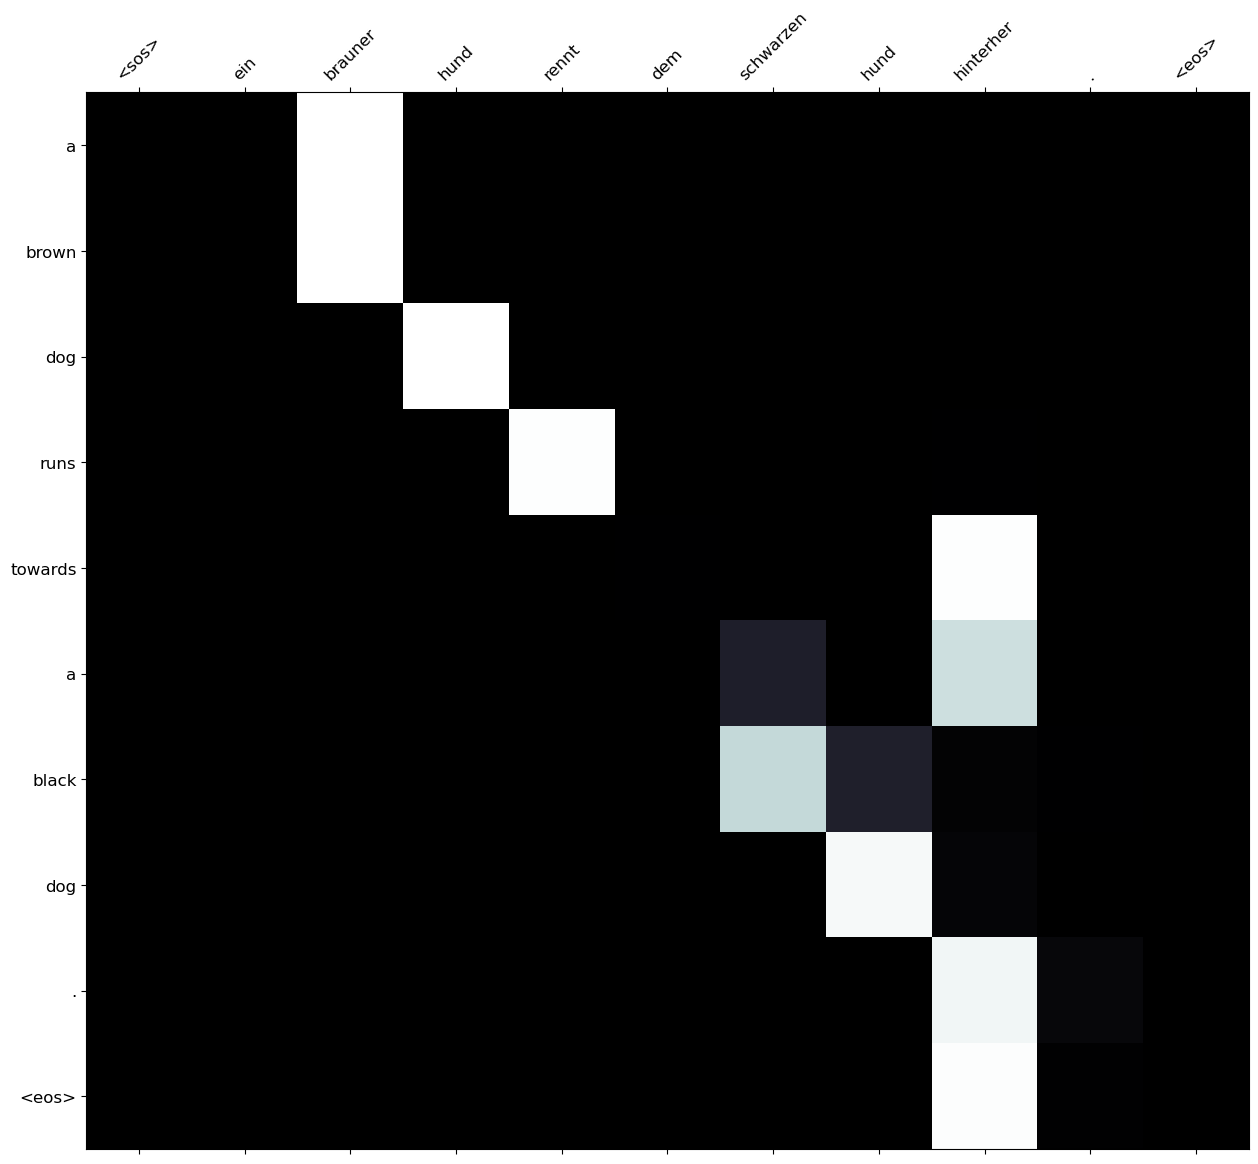

In [481]:
display_attention(src, translation, attention)

### BLEU
- Calculate BLEU for test set

In [474]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [475]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 29.55
